# Analysis of intrinsic results: GeoDanmark

In [212]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import h3

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_refdata.py

<string>:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Reference data loaded successfully!


In [213]:
# Read intrinsic grid results
with open(
    f"../results/REFERENCE/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    ref_intrinsic_grid = pickle.load(fp)

# Import intrinsic results
ref_intrinsic_file = open(
    f"../results/REFERENCE/{study_area}/data/intrinsic_analysis.json"
)

ref_intrinsic_results = json.load(ref_intrinsic_file)

# Import summary dataframe
summarize_results_df = pd.read_csv(f"../results/REFERENCE/{study_area}/data/intrinsic_summary_results.csv",index_col=0)

summarize_results_df.style.pipe(format_ref_style)

,
Total infrastructure length (km),"8,676"
Protected bicycle infrastructure density (m/km2),92
Unprotected bicycle infrastructure density (m/km2),95
Mixed protection bicycle infrastructure density (m/km2),0
Bicycle infrastructure density (m/km2),187
Nodes,"51,224"
Dangling nodes,"11,218"
Nodes per km2,1
Dangling nodes per km2,0
Overshoots,99


## Municipal Analysis

In [214]:
# Read muni data
muni = gpd.read_file("../data/municipalities.gpkg")
muni = muni[['navn','kommunekode','geometry']]
assert muni.crs == study_crs

**Assign municipal ID/name to all grid cells**

In [215]:
# Assign municipal name and id to each hex cell based on centroid overlap
ref_intrinsic_grid.dropna(subset='count_ref_edges',inplace=True)

grid_centroids = ref_intrinsic_grid[['geometry','grid_id','count_ref_edges']].copy()
grid_centroids['geometry'] = grid_centroids.geometry.centroid

centroid_join = grid_centroids.sjoin(muni, predicate="intersects", how="inner")
centroid_join.drop('index_right',axis=1,inplace=True)

non_joined_centroid = grid_centroids[grid_centroids.count_ref_edges.notna() & ~grid_centroids.grid_id.isin(centroid_join.grid_id)] #drop(['navn','kommunekode'],axis=1)

centroid_join_2 = non_joined_centroid.sjoin_nearest(muni, how="left",distance_col='dist')

assert len(centroid_join_2) + len(centroid_join) == len(ref_intrinsic_grid)

joined_int_grid = pd.concat([centroid_join_2,centroid_join])

assert len(joined_int_grid) == len(ref_intrinsic_grid)

int_grid = ref_intrinsic_grid.merge(joined_int_grid[['grid_id','navn','kommunekode']],left_on='grid_id',right_on='grid_id')
assert len(int_grid) == len(ref_intrinsic_grid)

**Index nodes and edges by municipality**

In [216]:
# Index nodes and edges by municipality
muni_edges = ref_edges_simplified.sjoin(muni,how="left",predicate="intersects")
muni_edges.drop('index_right',axis=1,inplace=True)

nodes_joined = gpd.sjoin(muni, ref_nodes_simplified, how="right",predicate="contains")
nodes_joined.drop('index_left',axis=1,inplace=True)

nodes_joined_2 = gpd.sjoin_nearest(muni, nodes_joined[nodes_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
nodes_joined_2.drop('index_left',axis=1,inplace=True)
nodes_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

nodes_joined.dropna(subset='navn',inplace=True)

muni_nodes = pd.concat([nodes_joined,nodes_joined_2])

assert len(muni_nodes) == len(ref_nodes_simplified)
assert len(muni_nodes) == len(muni_nodes.nodeID.unique())
assert len(muni_nodes[muni_nodes.navn.isna()]) == 0
assert len(muni_edges[muni_edges.navn.isna()]) == 0

# Recompute length - for GeoDK, infra length is equal to geom length
muni_edges['infrastructure_length'] = muni_edges.geometry.length

# Index dangling nodes by muni
dang_joined = gpd.sjoin(muni, ref_dangling, how="right",predicate="contains")
dang_joined.drop('index_left',axis=1,inplace=True)

dang_joined_2 = gpd.sjoin_nearest(muni, dang_joined[dang_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
dang_joined_2.drop('index_left',axis=1,inplace=True)

dang_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

dang_joined.dropna(subset='navn',inplace=True)

muni_dang = pd.concat([dang_joined,dang_joined_2])

assert len(muni_dang) == len(ref_dangling)
assert len(muni_dang) == len(muni_dang.nodeID.unique())
assert len(muni_dang[muni_dang.navn.isna()]) == 0
assert len(muni_dang[muni_dang.navn.isna()]) == 0

# Group by muni
grouped_edges = muni_edges.groupby("navn") 
grouped_nodes = muni_nodes.groupby("navn")
grouped_dangling = muni_dang.groupby("navn")

# Turn into dataframe
muni_infra = grouped_edges['infrastructure_length'].sum().to_frame()

muni_node_count = grouped_nodes.size().to_frame('node_count') 

muni_dang_count = grouped_dangling.size().to_frame('dangling_node_count') 

muni_network_counts = pd.merge(pd.merge(muni_infra, muni_node_count,left_index=True, right_index=True),muni_dang_count,left_index=True, right_index=True)

assert len(muni_network_counts) == 98


**Plot length of bicycle infrastructure, bicycle infrastructure density and infrastructure per 1000 people**

Text(0.5, 1.0, 'Bicycle Infrastructure Density: Per 1.000 People')

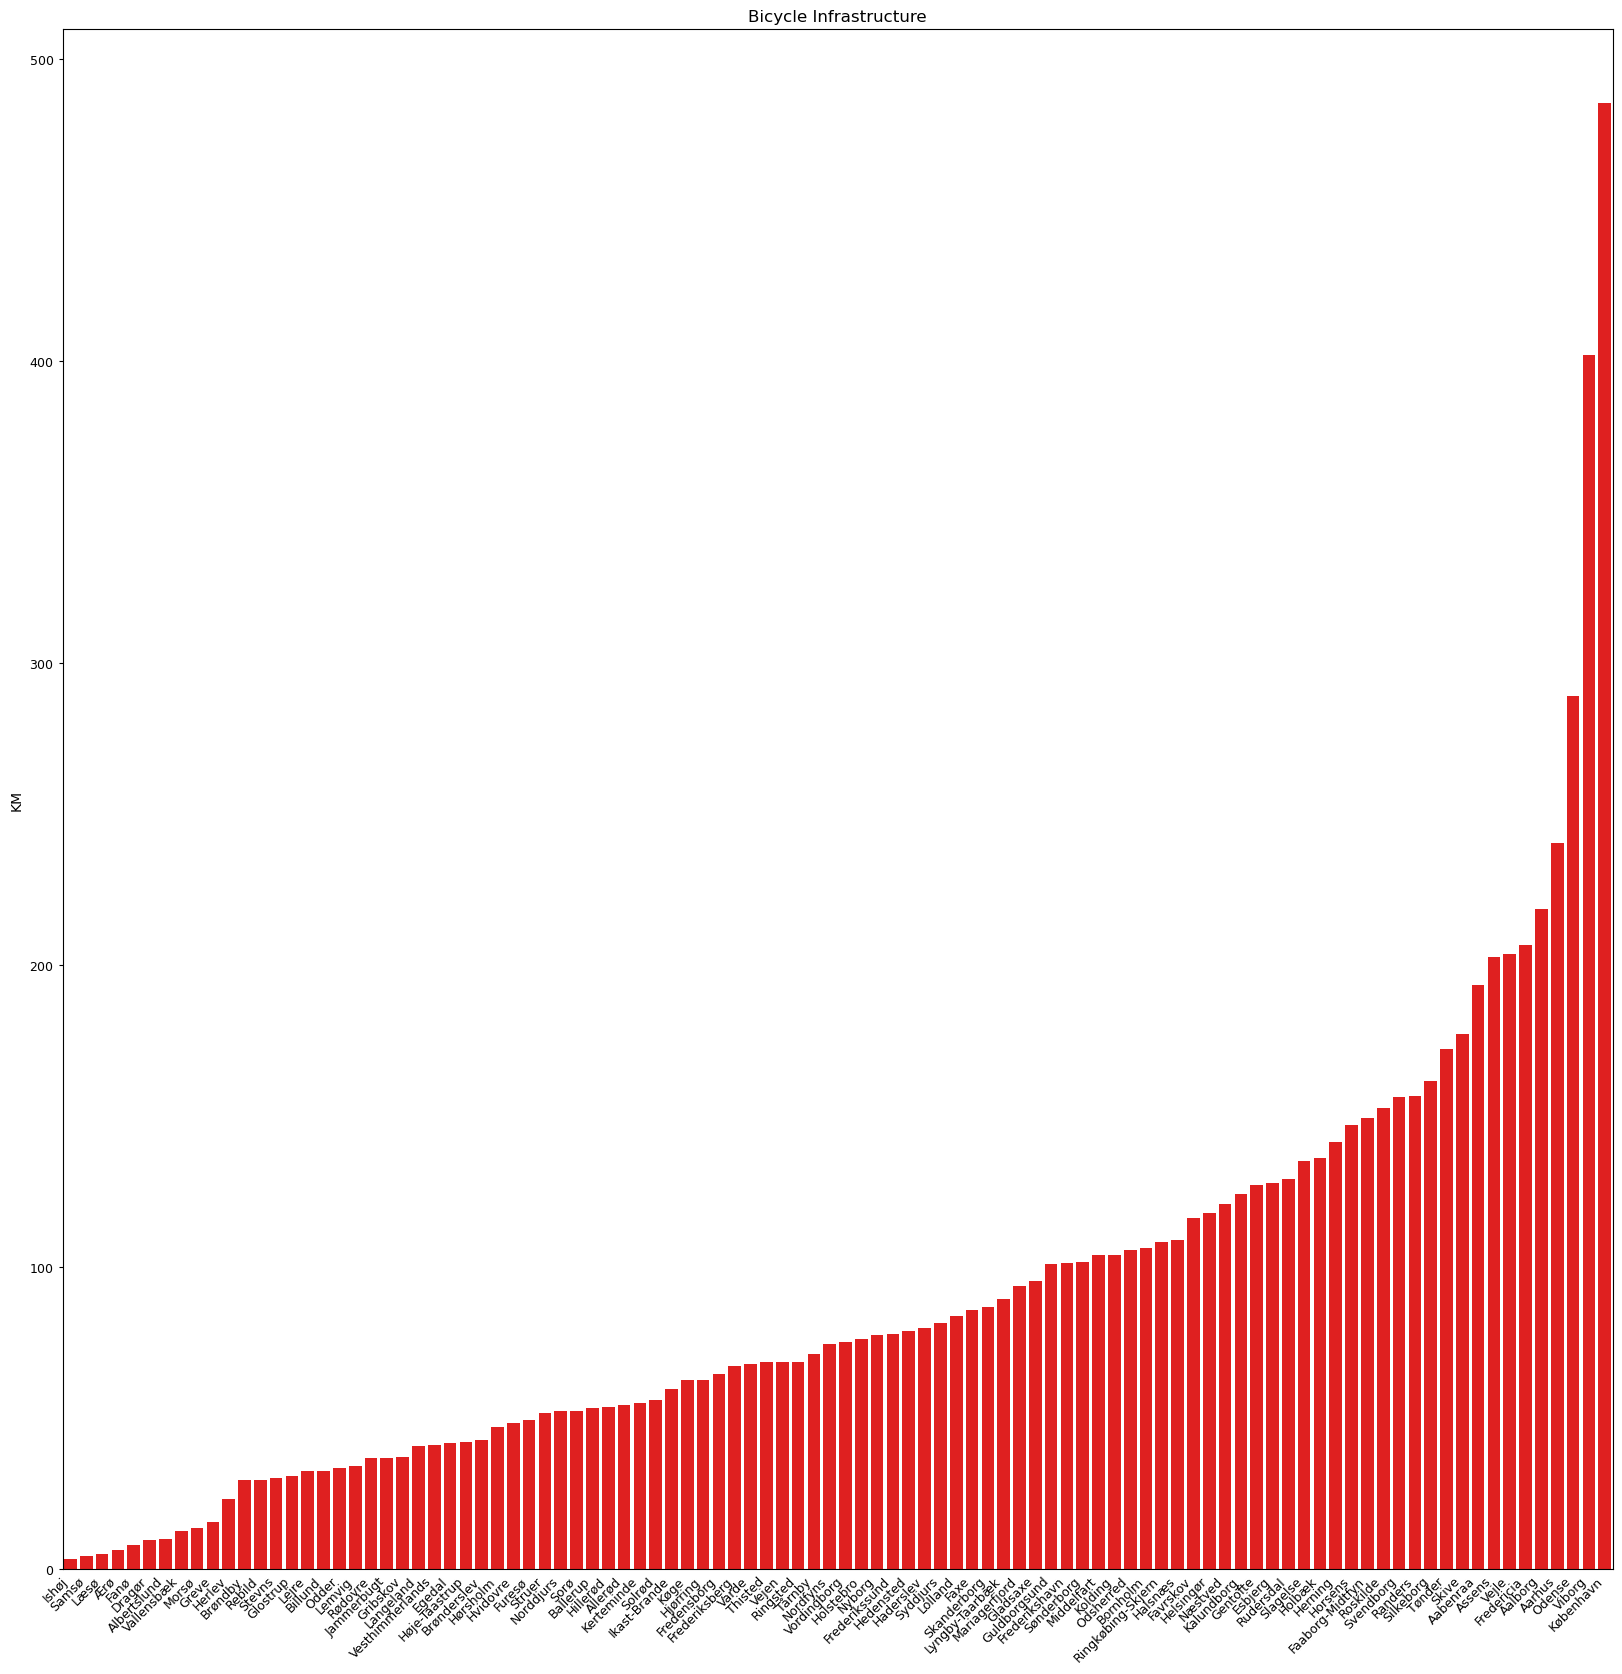

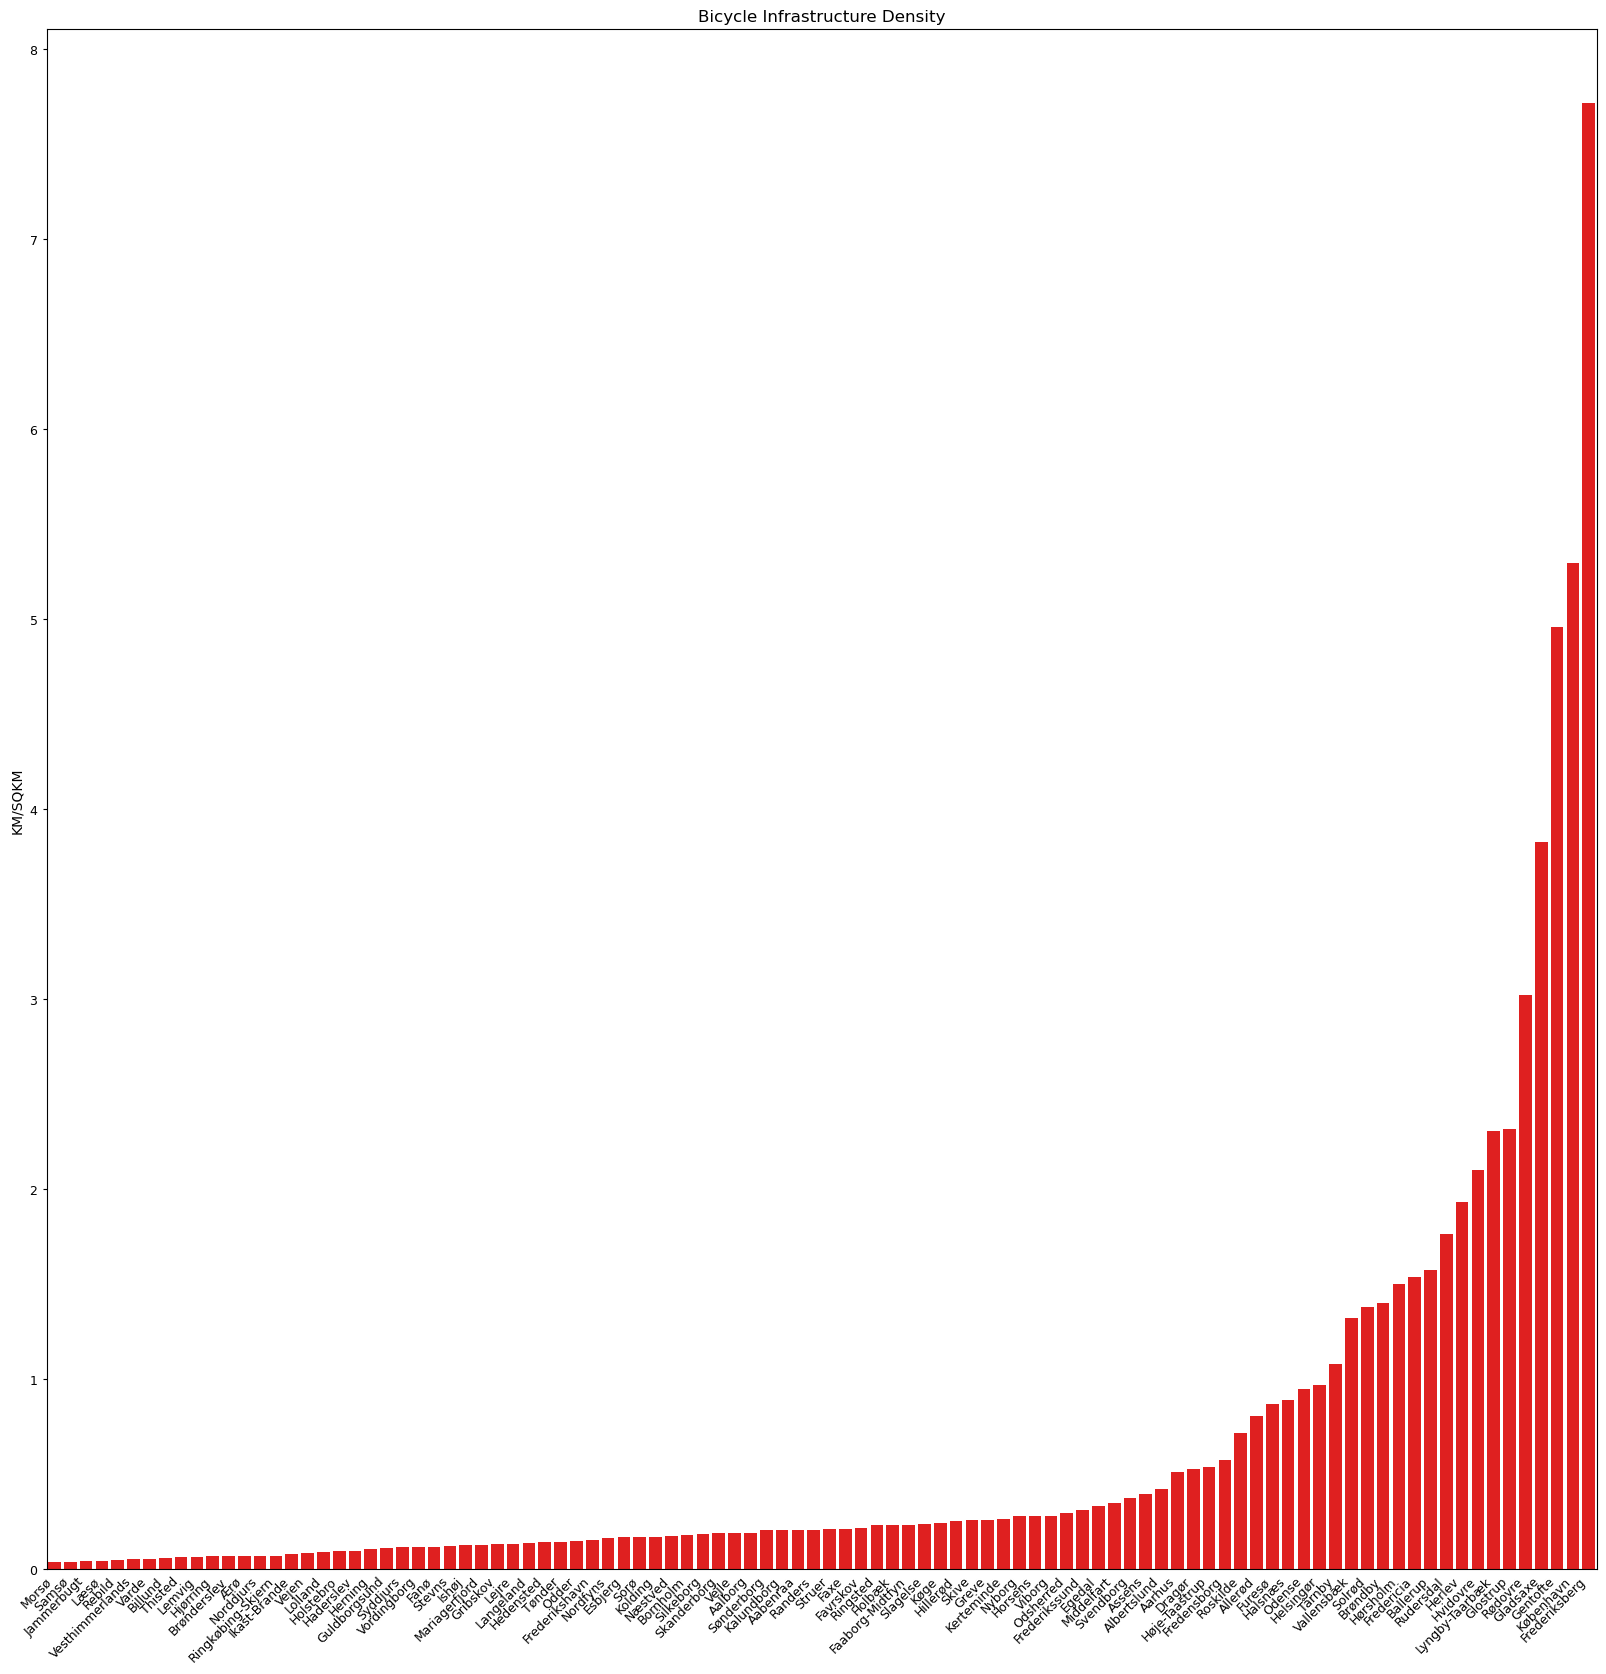

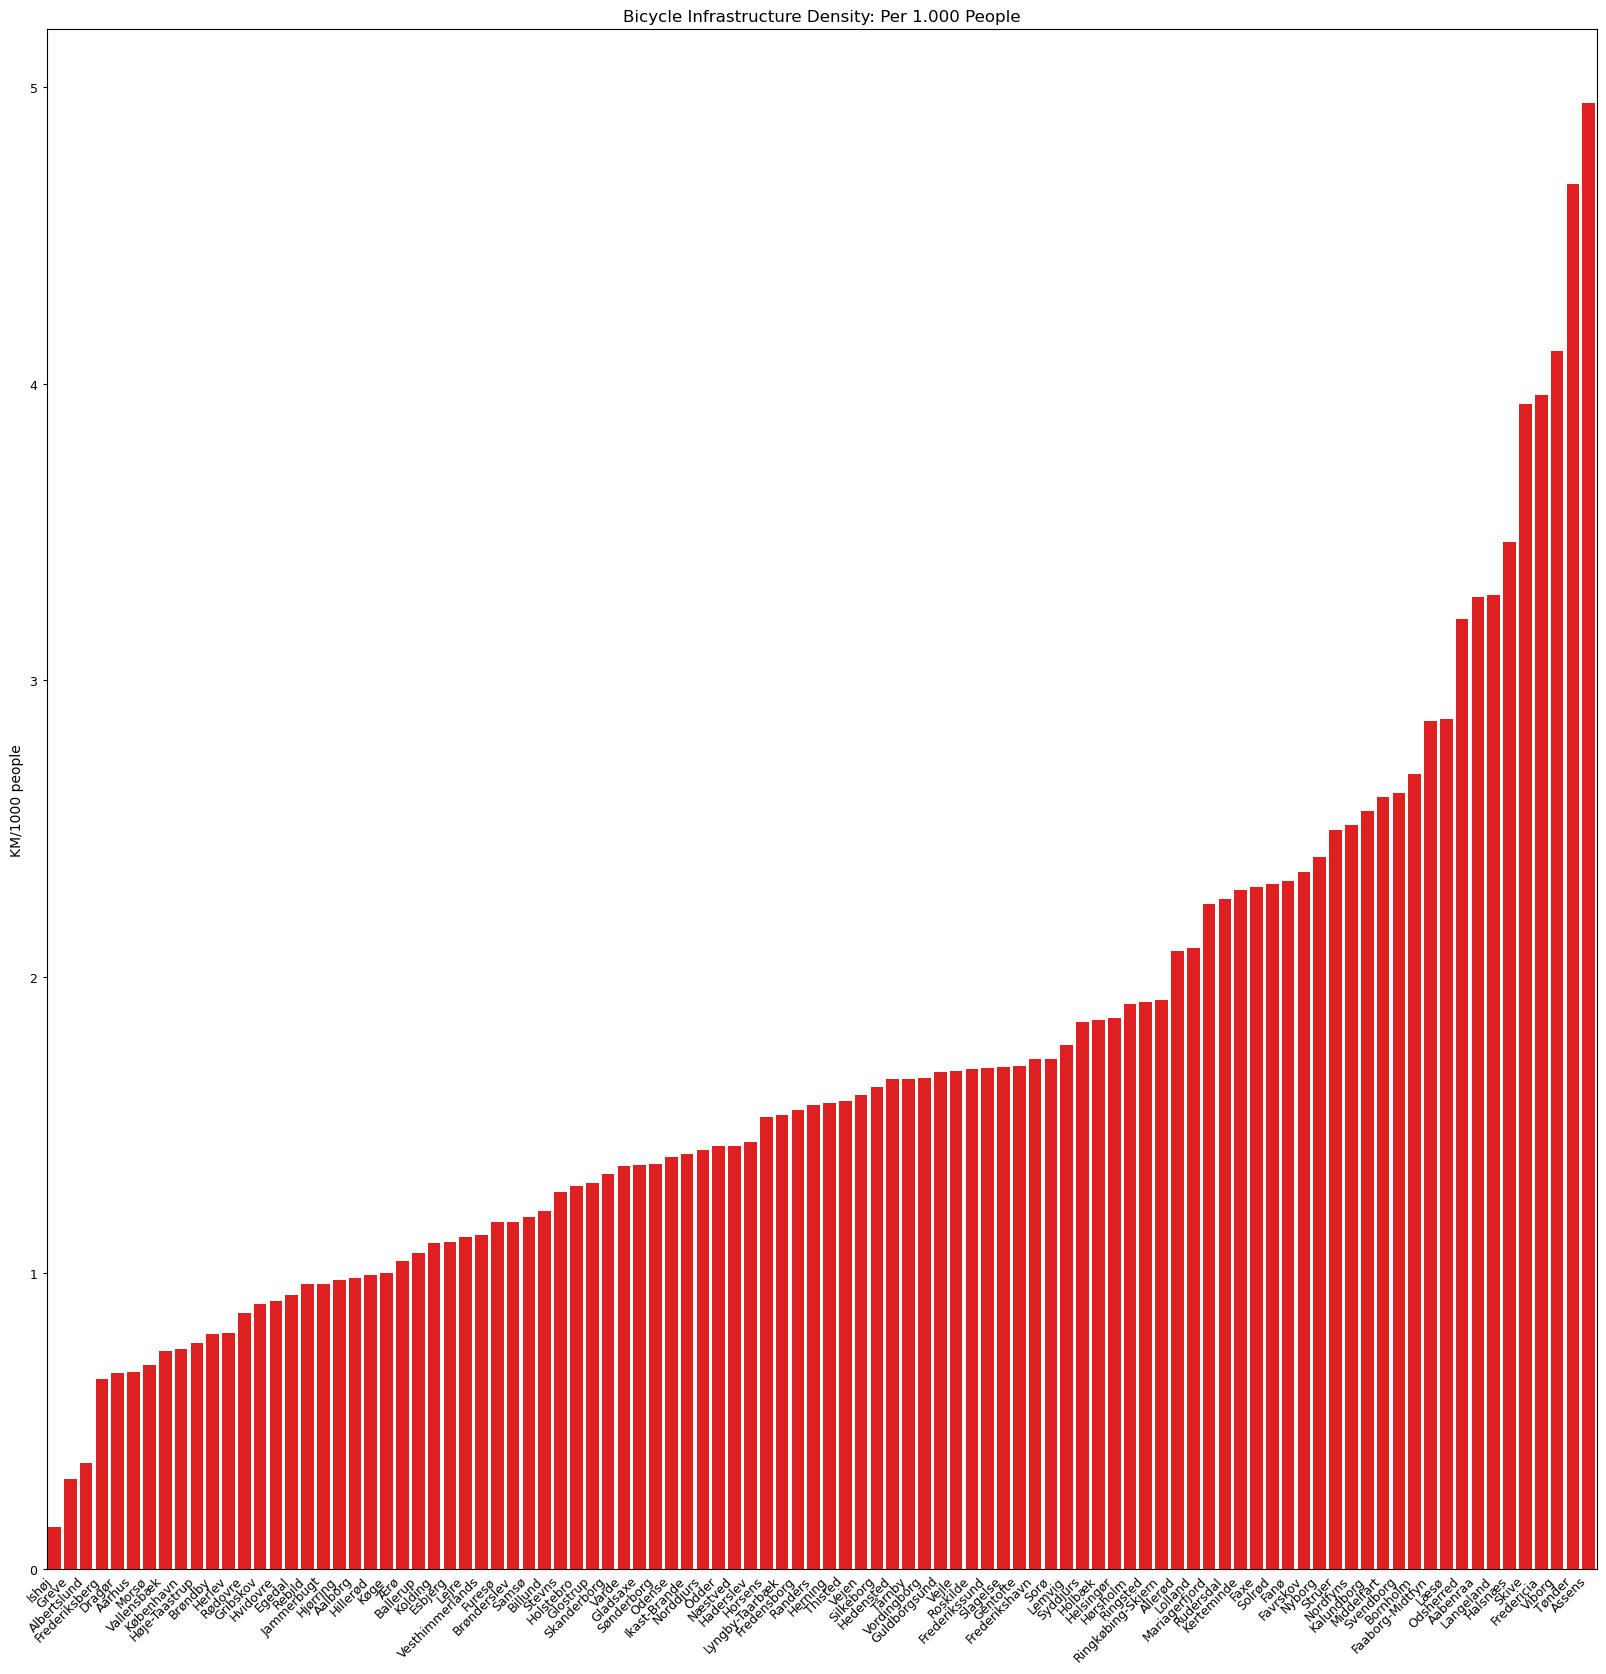

In [217]:
# Plot km of bicycle infra per muni
muni_network_counts["infra_km"] = round(
    muni_network_counts.infrastructure_length / 1000, 3
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_km"),
    x="navn",
    y="infra_km",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM")
plt.title("Bicycle Infrastructure")

# Plot infra density per muni
muni["area_sqkm"] = round(muni.area / 1000000, 2)

muni_network_counts = muni_network_counts.merge(
    muni[["navn", "area_sqkm"]], left_index=True, right_on="navn"
)

muni_network_counts["infra_dens"] = round(
    muni_network_counts.infra_km / muni_network_counts.area_sqkm, 3
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_dens"),
    x="navn",
    y="infra_dens",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM/SQKM")
plt.title("Bicycle Infrastructure Density")

# Plot infra per pop
muni_pop = pd.read_csv("../data/muni_pop.csv", encoding="ISO-8859-1", header=None)
muni_pop.rename({1: "navn", 2: "pop"}, inplace=True, axis=1)

muni_network_counts = muni_network_counts.merge(
    muni_pop[["navn", "pop"]], left_on="navn", right_on="navn"
)
assert len(muni_network_counts) == 98

muni_network_counts["infra_pop"] = muni_network_counts.infra_km / (
    muni_network_counts["pop"] / 1000
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(
    muni_network_counts.reset_index().sort_values("infra_pop"),
    x="navn",
    y="infra_pop",
    ax=ax,
    color="red",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("KM/1000 people")
plt.title("Bicycle Infrastructure Density: Per 1.000 People")


**Index over and undershoots by municipality**

In [218]:
# Join over and undershoot to muni
overshoot_edge_ids = pd.read_csv(ref_results_data_fp+"overshoot_edges_3.csv")
undershoot_node_ids = pd.read_csv(ref_results_data_fp+"undershoot_nodes_3.csv")

undershoots = ref_nodes_simplified[ref_nodes_simplified.nodeID.isin(undershoot_node_ids.node_id)]
assert len(undershoot_node_ids) == len(undershoots)

overshoots = ref_edges_simplified[ref_edges_simplified.edge_id.isin(overshoot_edge_ids.edge_id)]
assert len(overshoot_edge_ids) == len(overshoots)

# Join to muni
over_muni = overshoots[['edge_id','geometry']].sjoin(muni,how='left',predicate='intersects')

under_muni = undershoots[['nodeID','geometry']].sjoin(muni,how='left', predicate='intersects')

assert len(over_muni) == len(overshoots)
assert len(under_muni) == len(undershoots)

# Group by muni and count
over_df = over_muni.groupby('navn').size().to_frame('overshoots')

under_df = under_muni.groupby('navn').size().to_frame('undershoots')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, over_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts = pd.merge(muni_network_counts, under_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['over_under'] = muni_network_counts.overshoots + muni_network_counts.undershoots
muni_network_counts['over_under'].fillna(0,inplace=True)

**Join over and undershoots to grid cells**

In [219]:
# Join over and undershoots to grid ids
overshoots_grid = overshoots[['edge_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='edge_id',keep="first")[['grid_id']].reset_index(drop=True)
undershoots_grid = undershoots[['nodeID','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='nodeID',keep="first")[['grid_id']].reset_index(drop=True)

over_grid_grouped = overshoots_grid.groupby('grid_id').size().to_frame('overshoots_count')
under_grid_grouped = undershoots_grid.groupby('grid_id').size().to_frame('undershoots_count')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(over_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid = int_grid.merge(under_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['overshoots_count'].fillna(0,inplace=True)
int_grid['undershoots_count'].fillna(0,inplace=True)


**Join component gaps to municipality**

In [220]:
comp_gaps = gpd.read_file(ref_results_data_fp+"component_gaps_centroids_10.gpkg")
comp_gaps.head()

# Join to muni
gaps_muni = comp_gaps.sjoin(muni,how='left',predicate='intersects')

assert len(gaps_muni) == len(comp_gaps)

# Group by muni and count
gaps_df = gaps_muni.groupby('navn').size().to_frame('component_gaps')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, gaps_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['component_gaps'] = muni_network_counts.component_gaps.fillna(0).astype(int)

**Join component gaps to grid cells**

In [221]:
comp_gaps['gap_id'] = comp_gaps.index

gaps_grid = comp_gaps[['gap_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='gap_id',keep="first")[['grid_id']].reset_index(drop=True)
assert len(gaps_grid) == len(comp_gaps)

gaps_grouped = gaps_grid.groupby('grid_id').size().to_frame('component_gaps')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(gaps_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['component_gaps'] = int_grid['component_gaps'].fillna(0).astype(int)

**Correlation between infrastructure length and topology errors**

In [222]:
# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_gaps',
    title='Correlation between infrastructure length and component gaps', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "component_gaps": "Gaps between disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='over_under',
    title='Correlation between infrastructure length and topology errors', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "over_under": "Over and undershoots",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


**Index components by municipality**

In [223]:
muni_grid = int_grid.groupby('navn')

muni_components = {}

for name, group in muni_grid:
    nested_list = group.component_ids_ref.to_list()
    flat_list = list(set([item for sublist in nested_list for item in sublist]))

    muni_components[name] = len(flat_list)

muni_comp_df = pd.DataFrame.from_dict(muni_components,orient='index',columns=['component_count']).reset_index().rename({'index':'navn'},axis=1)
assert len(muni_comp_df) == 98

muni_network_counts = muni_network_counts.merge(muni_comp_df, left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98


**Export**

In [224]:
# Export
assert len(muni_network_counts) == 98
muni_network_counts.to_csv("../results/geodk_quality/muni_network_counts.csv", index=False)

int_grid.to_parquet("../results/geodk_quality/int_grid.parquet")

**Plot scatterplots of correlation between number of components and infrastructure length, area, and density**

In [225]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_count',
    title='Correlation between infrastructure length and number of components', 
    hover_data=['navn'],
    color="area_sqkm",
    color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between municipality size and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='area_sqkm', 
    y='component_count',
    color="infra_km",
    title='Correlation between municipality size and number of components', 
    hover_data=['navn'],
    color_continuous_scale='viridis_r',
    labels={
        "area_sqkm": "Size (sqkm)",
        "infra_km": "Length (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between density and number of components
fig = px.scatter(
    muni_network_counts, 
    x='infra_dens', 
    y='component_count',
    #color="infra_km",
    title='Correlation between infrastructure density and number of components', 
    hover_data=['navn'],
    #color_continuous_scale='viridis_r',
    labels={
        # "area_sqkm": "Size (sqkm)",
        # "infra_km": "Length (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()


**Plot all over and undershoots**

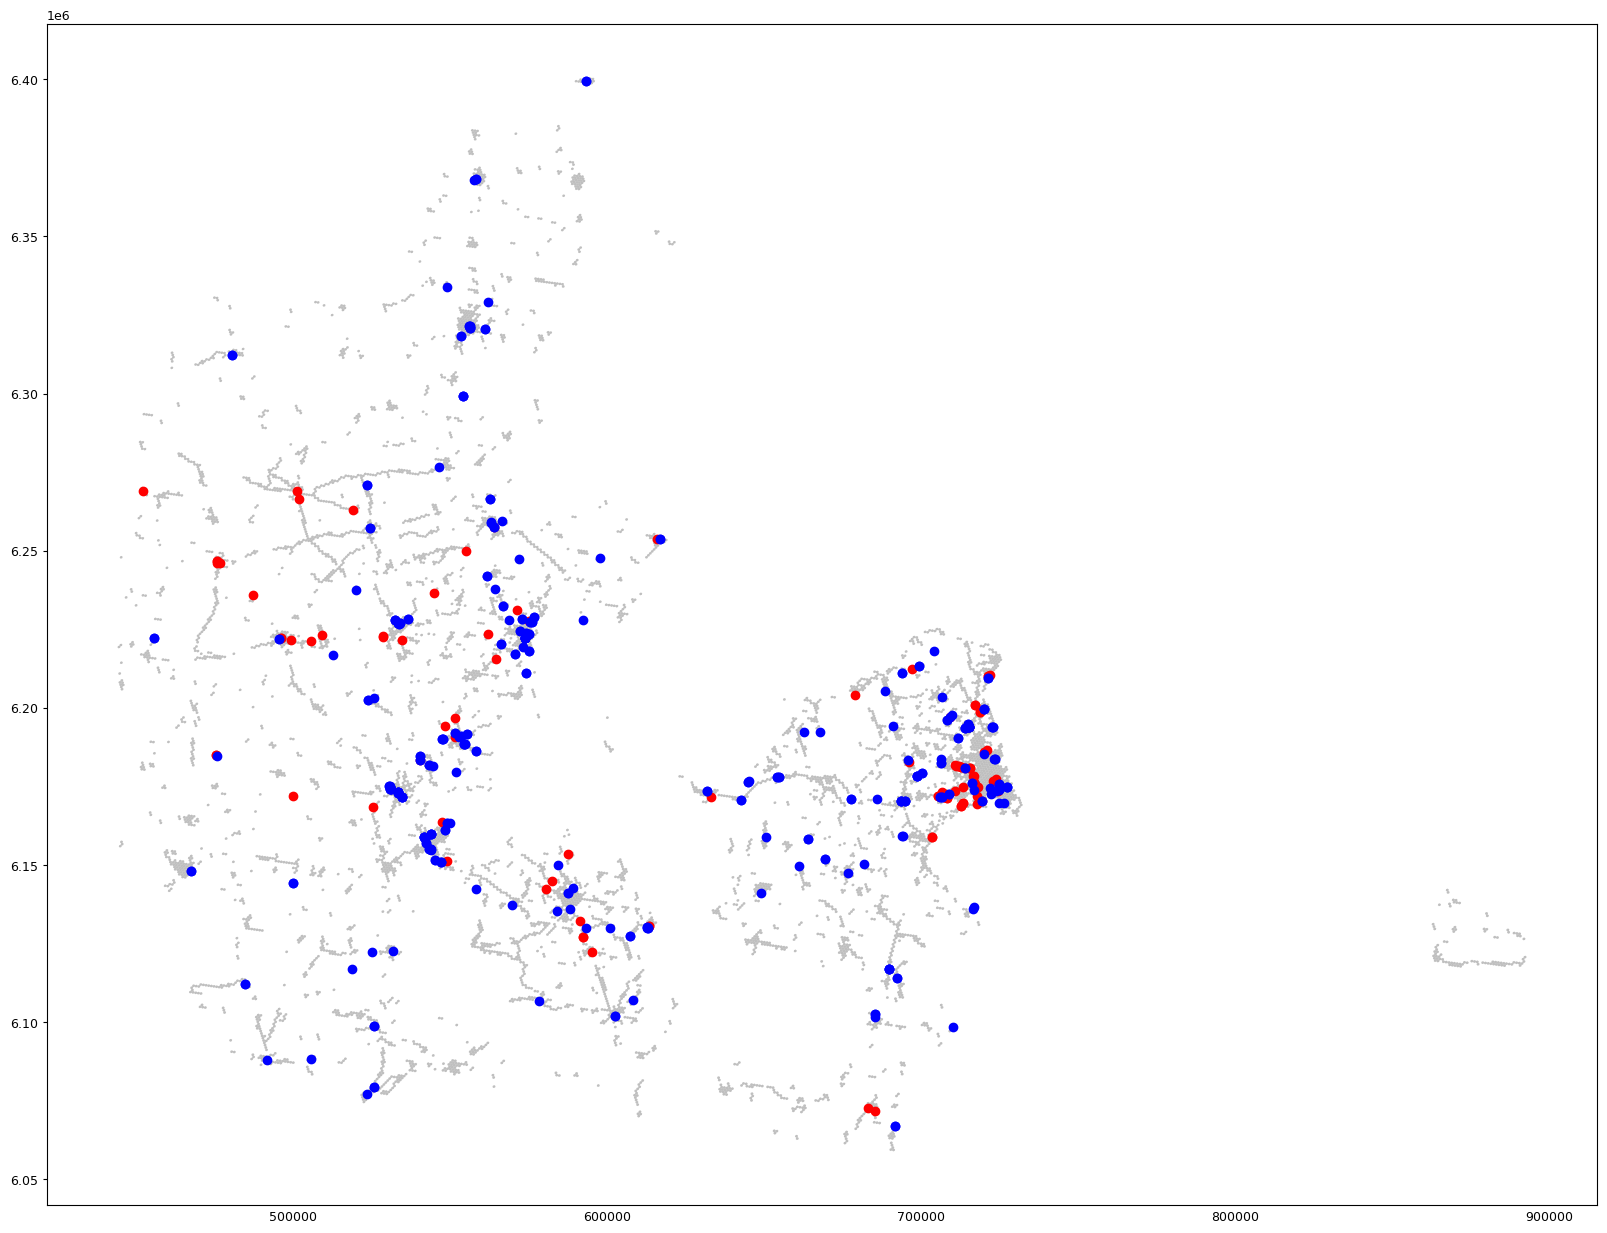

In [226]:
fig, ax = plt.subplots(figsize=(20,20))

int_grid.plot(ax=ax,alpha=0.5,color='grey')
overshoots_cent = overshoots.copy()
overshoots_cent['geometry'] = overshoots.centroid
overshoots_cent.plot(ax=ax,color='red')
undershoots.plot(ax=ax,color='blue');

## Spatial patterns in topology errors

- smooth density - quantify high dens
- smooth errors? - quanity high errors
- write down question?

Are there any areas with more topology errors than expected given the length/amount/density of infrastructure in the area?

1. Normalize number of topology errors with density
    1. For each grid cell: Get the km of bicycle infra in:
        - Distance band / K-rings
    2. Divide number of errors with km of infra value
2. Analyze patterns of normalized values



**EXPLANATION HERE**

In [228]:
hexid = int_grid.loc[0,'hex_id']

h3_res = h3.h3_get_resolution(hexid)
print("The hexagons are at resolution:", h3_res)

k = eval_func.radius_to_k_ring(2, h3_res)

int_grid['k_rings'] = int_grid.apply(lambda x: h3.k_ring(x.hex_id, k),axis=1)

int_grid['area_sqkm'] = int_grid.area / 1000000

int_grid['local_length'] = int_grid.apply(lambda x: eval_func.get_local_network_length(int_grid, 'ref_edge_density', 'area_sqkm', x.k_rings),axis=1)

The hexagons are at resolution: 8
The average edge length is: 0.461354684
The distance band will have a radius 2.31 km


In [230]:
#from pysal.viz import splot
#from splot.libpysal import plot_spatial_weights
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import lisa_cluster


/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/lib/weights/weights.py:167: UserWarning:

There are 212 disconnected observations 
  Island ids: 6, 24, 26, 49, 91, 105, 140, 144, 199, 218, 233, 239, 249, 265, 288, 291, 299, 308, 383, 396, 409, 413, 467, 483, 498, 545, 599, 691, 752, 783, 832, 900, 951, 958, 972, 1011, 1047, 1101, 1117, 1118, 1159, 1199, 1200, 1250, 1323, 1386, 1416, 1421, 1474, 1556, 1567, 1572, 1615, 1644, 1685, 1694, 1717, 1749, 1805, 1806, 1810, 1827, 1841, 1843, 1873, 1920, 1991, 1998, 2013, 2031, 2102, 2133, 2134, 2183, 2190, 2230, 2251, 2264, 2283, 2286, 2321, 2338, 2351, 2358, 2397, 2414, 2430, 2452, 2493, 2521, 2523, 2597, 2739, 2758, 2805, 2807, 2820, 2869, 2874, 2920, 2924, 2942, 3015, 3084, 3105, 3109, 3172, 3219, 3222, 3225, 3257, 3275, 3294, 3364, 3382, 3392, 3397, 3423, 3469, 3527, 3529, 3579, 3582, 3616, 3679, 3681, 3697, 3722, 3744, 3774, 3804, 3810, 3812, 3847, 3861, 3909, 3927, 3994, 4086, 4104, 4190, 4214, 4223, 4299, 4349, 4

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 91, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 199, ' is an island (no neighbors)')
('WARNING: ', 218, ' is an island (no neighbors)')
('WARNING: ', 233, ' is an island (no neighbors)')
('WARNING: ', 239, ' is an island (no neighbors)')
('WARNING: ', 249, ' is an island (no neighbors)')
('WARNING: ', 265, ' is an island (no neighbors)')
('WARNING: ', 288, ' is an island (no neighbors)')
('WARNING: ', 291, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 308, ' is an island (no neighbors)')
('WARNING: ', 383, ' is an island (no neighbors)')
('WARNING: ', 396, ' is an island (no

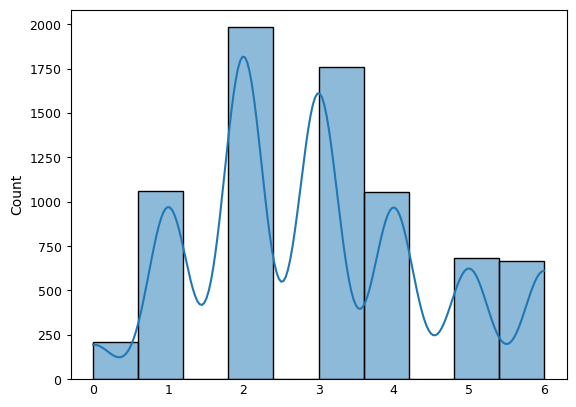

In [245]:
cents = int_grid.centroid

# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values

w = weights.distance.DistanceBand.from_array(
    pts, 1000, binary=False
)

# row standardize
w.transform = "R"

sns.histplot(w.cardinalities, bins=10, kde=True);

In [246]:
error_types = ['undershoots_count','overshoots_count','component_gaps']

for i in error_types:
    None

int_grid['undershoot_dens'] = int_grid.undershoots_count / (int_grid.local_length/1000) # ref_edge_density  #edge_dens_lag

int_grid["undershoot_lag"] = weights.spatial_lag.lag_spatial(
    w, int_grid["undershoot_dens"]
)

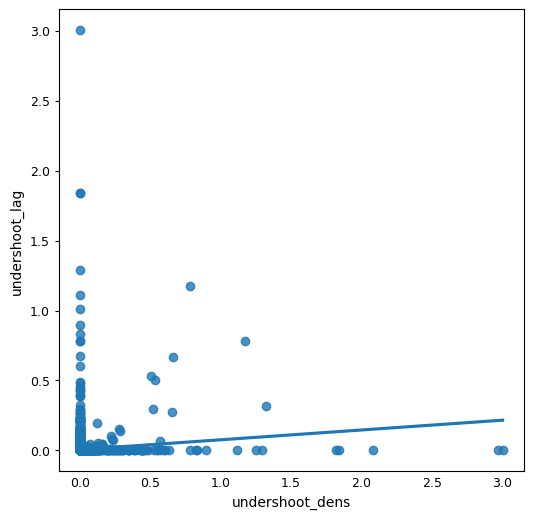

In [247]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="undershoot_dens", y="undershoot_lag", data=int_grid, ci=None
)
plt.show()

In [248]:
lisa = esda.moran.Moran_Local(int_grid['undershoot_dens'], w)

In [254]:
moran = esda.moran.Moran(int_grid["undershoot_dens"], w)

In [255]:
moran.I

0.07255587520862931

In [256]:
moran.p_sim

0.004

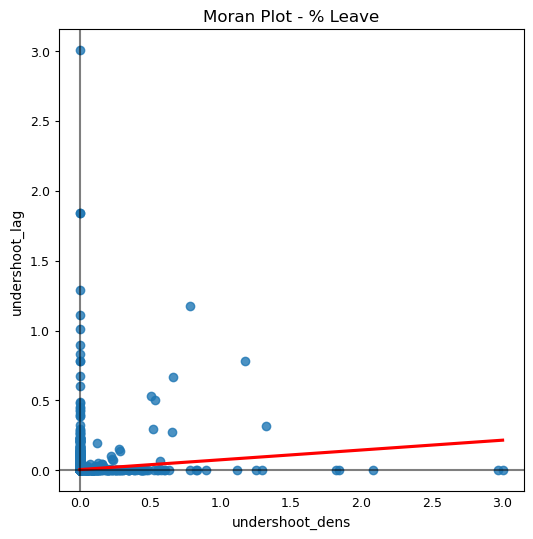

In [258]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="undershoot_dens",
    y="undershoot_lag",
    ci=None,
    data=int_grid,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

In [249]:
set(lisa.q)

{1, 2, 3, 4}

In [250]:
int_grid['q'] = lisa.q

In [251]:
lisa.Is

array([0.00741201, 0.00741201, 0.00741201, ..., 0.00741201, 0.00741201,
       0.00741201])

In [252]:
db = int_grid

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/mapclassify/classifiers.py:255: UserWarning:

Not enough unique values in array to form 3 classes. Setting k to 2.



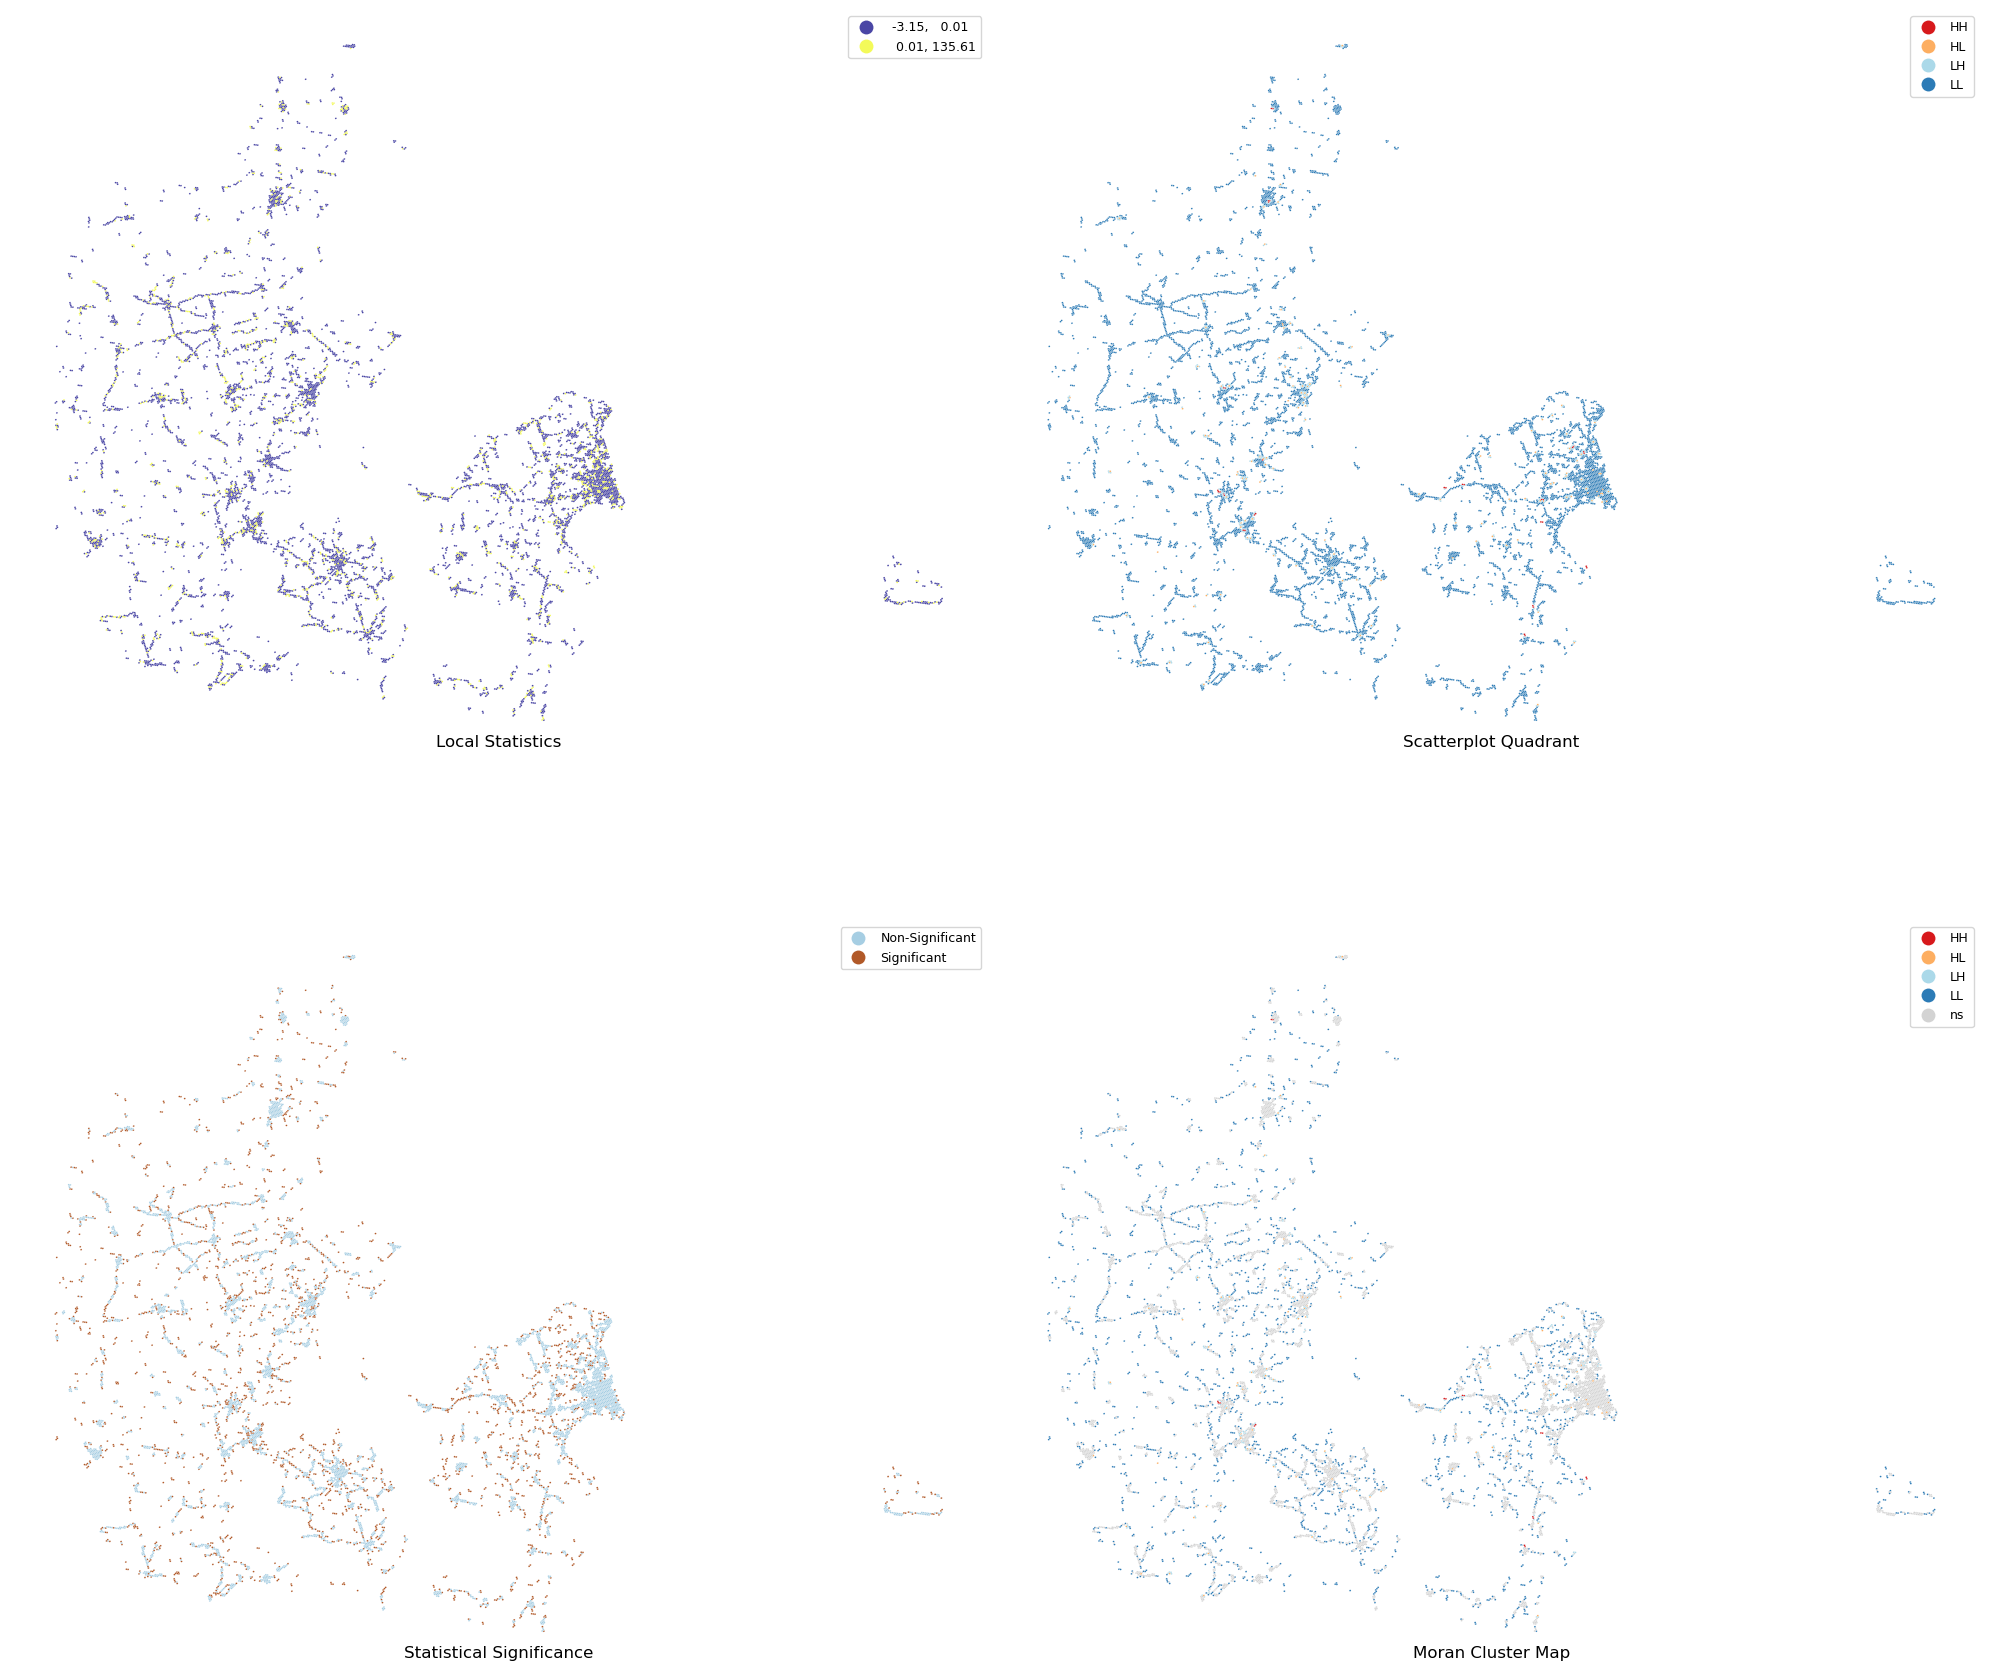

In [253]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=3,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()